In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import romspline
from scipy.interpolate import InterpolatedUnivariateSpline as spline

In [3]:
import lal
import lalsimulation as LS

MP June 2017

## TEOB generation

In [2]:
def spin_tidal_eob(m1, m2, s1z, s2z, lambda1, lambda2,
                    f_min, 
                    delta_t=1.0/16384.0, distance=1.0, inclination=0.0,
                    approximant='TEOBv4', verbose=True):
    """EOB waveform with aligned spin and tidal interactions. 
    l=3 tidal interaction and l=2,3 f-mode calculated with universal relations.
    
    Parameters
    ----------
    approximant : 'TEOBv2' or 'TEOBv4'
        Based on the inspiral model given by 'SEOBNRv2' or 'SEOBNRv4'.
    
    Returns
    -------
    Waveform object
    """
    # print m1, m2, s1z, s2z, lambda1, lambda2, f_min, delta_t, distance, inclination
    f_ref = 0.
    phiRef = 0.
    
    # Must have aligned spin
    s1x, s1y, s2x, s2y = 0., 0., 0., 0.
    
    # Eccentricity is not part of the model
    longAscNodes = 0.
    eccentricity = 0.
    meanPerAno = 0.
    
    # Set the EOB approximant
    if (approximant not in ['TEOBv2', 'TEOBv4']):
        raise Exception, "Approximant must be 'TEOBv2' or 'TEOBv4'."
    lal_approx = LS.GetApproximantFromString(approximant)
    
    
    # Calculate higher order matter effects from universal relations
    # lambda3 given in terms of lambda2
    lambda31_ur = LS.SimUniversalRelationlambda3TidalVSlambda2Tidal(lambda1)
    lambda32_ur = LS.SimUniversalRelationlambda3TidalVSlambda2Tidal(lambda2)
    # Omega2 given in terms of lambda2
    omega21_ur = LS.SimUniversalRelationomega02TidalVSlambda2Tidal(lambda1)
    omega22_ur = LS.SimUniversalRelationomega02TidalVSlambda2Tidal(lambda2)
    # Omega3 given in terms of lambda3 (not lambda2)
    omega31_ur = LS.SimUniversalRelationomega03TidalVSlambda3Tidal(lambda31_ur)
    omega32_ur = LS.SimUniversalRelationomega03TidalVSlambda3Tidal(lambda32_ur)

    # print 'Terms calculated from universal relations'
    # print lambda31_ur, lambda32_ur
    # print omega21_ur, omega22_ur
    # print omega31_ur, omega32_ur

    # Insert matter parameters
    lal_params = lal.CreateDict()
    LS.SimInspiralWaveformParamsInsertTidalLambda1(lal_params, lambda1)
    LS.SimInspiralWaveformParamsInsertTidalLambda2(lal_params, lambda2)
    LS.SimInspiralWaveformParamsInsertTidalOctupolarLambda1(lal_params, lambda31_ur)
    LS.SimInspiralWaveformParamsInsertTidalOctupolarLambda2(lal_params, lambda32_ur)
    LS.SimInspiralWaveformParamsInsertTidalQuadrupolarFMode1(lal_params, omega21_ur)
    LS.SimInspiralWaveformParamsInsertTidalQuadrupolarFMode2(lal_params, omega22_ur)
    LS.SimInspiralWaveformParamsInsertTidalOctupolarFMode1(lal_params, omega31_ur)
    LS.SimInspiralWaveformParamsInsertTidalOctupolarFMode2(lal_params, omega32_ur)
    
    if verbose:
        ap = LS.GetStringFromApproximant(lal_approx)
        L2A = LS.SimInspiralWaveformParamsLookupTidalLambda1(lal_params)
        L2B = LS.SimInspiralWaveformParamsLookupTidalLambda2(lal_params)
        L3A = LS.SimInspiralWaveformParamsLookupTidalOctupolarLambda1(lal_params)
        L3B = LS.SimInspiralWaveformParamsLookupTidalOctupolarLambda2(lal_params)
        w2A = LS.SimInspiralWaveformParamsLookupTidalQuadrupolarFMode1(lal_params)
        w2B = LS.SimInspiralWaveformParamsLookupTidalQuadrupolarFMode2(lal_params)
        w3A = LS.SimInspiralWaveformParamsLookupTidalOctupolarFMode1(lal_params)
        w3B = LS.SimInspiralWaveformParamsLookupTidalOctupolarFMode2(lal_params)
        print 'Approximant: '+str(ap)
        print 'm1={:.2f}, m2={:.2f}'.format(m1, m2)
        print 's1z={:.2f}, s2z={:.2f}'.format(s1z, s2z)
        print 'delta_t={:.6f}, 1/delta_t={:.5}, f_min={:.2f}'.format(delta_t, 1./delta_t, f_min)
        print 'L2A, L2B, L3A, L3B, w2A, w2B, w3A, w3B:'
        print '{:.1f}, {:.1f}, {:.1f}, {:.1f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(L2A, L2B, L3A, L3B, w2A, w2B, w3A, w3B)
        sys.stdout.flush()
    
    # Evaluate waveform
    hp, hc = LS.SimInspiralChooseTDWaveform(
        m1*lal.MSUN_SI, m2*lal.MSUN_SI, 
        s1x, s1y, s1z, s2x, s2y, s2z, 
        distance*lal.PC_SI,
        inclination, phiRef, longAscNodes, eccentricity, meanPerAno,
        delta_t, f_min, f_ref, lal_params, lal_approx)
    
    # Extract time array from lalsimulation's structures
    tstart = hp.epoch.gpsSeconds + hp.epoch.gpsNanoSeconds*1.0e-9 
    # Q: why is this needed? shouldn't we just align at the peak?
    ts = tstart + hp.deltaT*np.arange(hp.data.length)
    
    return ts, hp.data.data, hc.data.data
    #return wave.Waveform.from_hp_hc(ts, hp.data.data, hc.data.data)


In [4]:
t1, hp1, hc1 = spin_tidal_eob(2, 2, 0.5, 0.5, 1, 1, 100)
t3, hp3, hc3 = spin_tidal_eob(2*3, 2, 0.5, 0.5, 1, 1, 100)

Approximant: TEOBv4
m1=2.00, m2=2.00
s1z=0.50, s2z=0.50
delta_t=0.000061, 1/delta_t=1.6384e+04, f_min=100.00
L2A, L2B, L3A, L3B, w2A, w2B, w3A, w3B:
1.0, 1.0, 0.3, 0.3, 0.1820, 0.1820, 0.2396, 0.2396
Approximant: TEOBv4
m1=6.00, m2=2.00
s1z=0.50, s2z=0.50
delta_t=0.000061, 1/delta_t=1.6384e+04, f_min=100.00
L2A, L2B, L3A, L3B, w2A, w2B, w3A, w3B:
1.0, 1.0, 0.3, 0.3, 0.1820, 0.1820, 0.2396, 0.2396


## Different grids

  * Design a grid with a fixed number of samples per cycle
  * Compute a romspline phase grid

In [11]:
h = hp1 - 1j * hc1
t = t1
amp = np.abs(h)
phi = np.unwrap(np.angle(h))

In [107]:
spline_phi = romspline.ReducedOrderSpline(t, phi, verbose=True, deg=3,
                                              tol=5e-5, rel=False)

phiI = spline(t, phi)


Size 	Error
5 	86.876678374
6 	57.2917685147
7 	28.3082989743
8 	41.946286447
9 	49.7295571094
10 	32.9175391163
11 	34.0929146425
12 	10.8761577411
13 	7.12436810665
14 	6.55990348866
15 	6.94149618169
16 	2.76550051716
17 	2.31410930622
18 	2.9649446657
19 	1.91629345623
20 	1.82411294456
21 	1.22469857429
22 	0.853399969135
23 	1.09686784119
24 	0.993659327302
25 	0.299257006435
26 	0.320529065267
27 	0.299086006019
28 	0.27565246463
29 	0.435508560834
30 	0.208527565751
31 	0.119291263369
32 	0.117919343259
33 	0.100341186856
34 	0.0942727311533
35 	0.0879687521142
36 	0.0606862909092
37 	0.0566140769981
38 	0.0458475535013
39 	0.0416273107725
40 	0.0404531003264
41 	0.038074830451
42 	0.0260760273342
43 	0.0213016398939
44 	0.0209674035998
45 	0.019114452248
46 	0.0406301140879
47 	0.0163668852204
48 	0.0157304542472
49 	0.0149426585463
50 	0.0142080214689
51 	0.0121223148039
52 	0.0105383909856
53 	0.00915530559973
54 	0.00633719604556
55 	0.00470719599053
56 	0.00465046155296
5

In [93]:
# Load 10Hz data
import h5py

fp = h5py.File('TEOB_dataI.hdf5', 'r')

In [100]:
tL = fp['grid'][:]
phiL = fp['h_0']['phi'][:]

In [105]:
# number of cycles
-(min(phiL) - max(phiL))/(2*pi)

28384.286692353682

In [106]:
len(tL)

26409

<IPython.core.display.Javascript object>


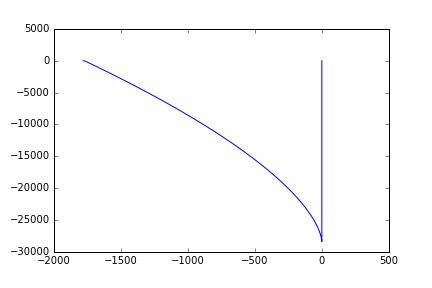

In [102]:
plot(tL, phiL/(2*pi))

In [82]:
phase_range = np.abs(phi[-1] - phi[0])
num_cycles = phase_range / (2*np.pi)
pts_per_cycle = 2.0
num_pts = pts_per_cycle * num_cycles
delta_phi = phase_range / num_pts
# or simply
delta_phi = 2*np.pi / pts_per_cycle
phase_grid = np.linspace(phi[0], phi[-1], 1 + int(phase_range / delta_phi))
tm, phim = monotonically_increasing_timeseries(t, -phi)
t_grid = spline(phim, tm)(-phase_grid)

In [79]:
def monotonically_increasing_timeseries(t, v, return_idx=False):
    """
Return the part of a timeseries where the independent and dependent
variables are not monotonically increasing from the start of the data
    """
    idx_t = np.where(np.diff(t) <= 0)[0]
    idx_v = np.where(np.diff(v) <= 0)[0]

    if len(idx_t) == 0:
        idx_t = len(t)
    else:
        idx_t = idx_t[0]
    if len(idx_v) == 0:
        idx_v = len(v)
    else:
        idx_v = idx_v[0]

    i = min(idx_t, idx_v)

    if return_idx:
        return i
    else:
        return t[:i], v[:i]

In [80]:
def is_monotonically_increasing(v):
    idx = np.where(np.diff(v) <= 0)[0]
    if len(idx) != 0:
        print 'is_monotonically_increasing(): violated for', idx, v[idx]
        #plt.plot(v, 'o-')
    return len(idx) == 0


In [83]:
is_monotonically_increasing(phim)
is_monotonically_increasing(tm)

True

In [87]:
spl = spline(phim, tm)

<IPython.core.display.Javascript object>


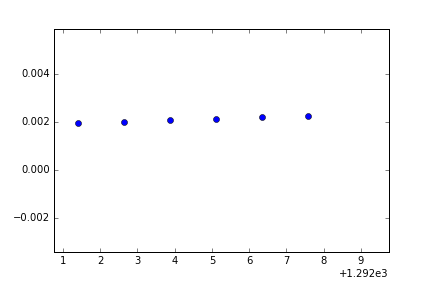

In [84]:
plot(phim, tm, 'o')

## How many points per cycle are in a romspline grid of the phase?

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()


<IPython.core.display.Javascript object>


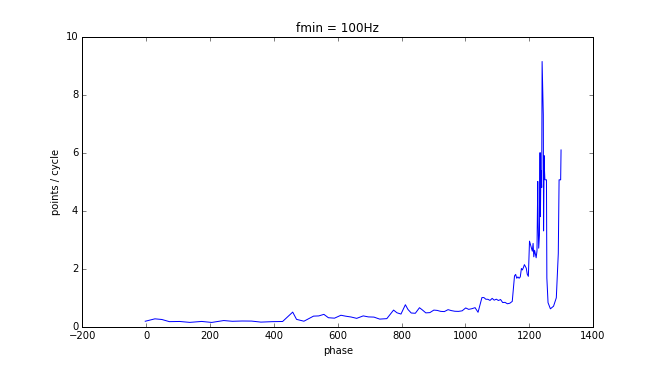

In [141]:
# points per cycle = 2*pi / d phi_grid
# np.abs((2*pi) / np.diff(phase_grid))
pts_per_cycle_romspline = np.abs((2*pi) / np.diff(phiI(spline_phi.X)))
idx_ok = np.where(pts_per_cycle_romspline < 1e10)
#plt.plot(spline_phi.X[idx_ok], pts_per_cycle_romspline[idx_ok])
plt.plot(-phiI(spline_phi.X[idx_ok]), pts_per_cycle_romspline[idx_ok])
plt.xlabel('phase')
plt.ylabel('points / cycle')
plt.title('fmin = 100Hz');

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in divide
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


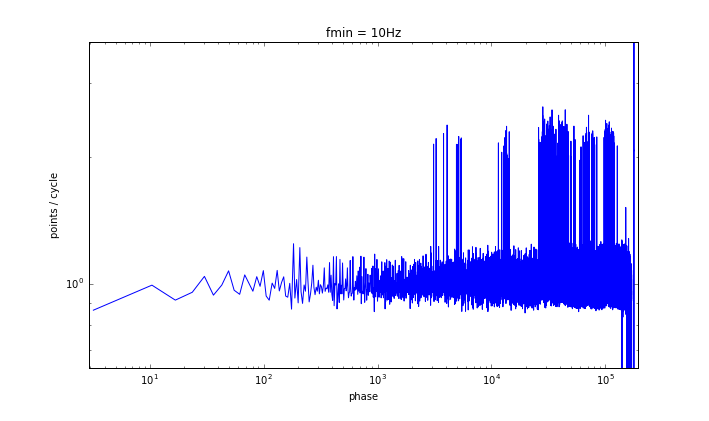

In [140]:
idx_ok = phiL.nonzero()
pts_per_cycle_romsplineL = -2*pi / np.diff(phiL[idx_ok])
phiLok = phiL[idx_ok]
tLok = tL[idx_ok]
idx_ok2 = np.where((pts_per_cycle_romsplineL < 1e10) & (pts_per_cycle_romsplineL > 0.0))
plt.loglog(-phiLok[idx_ok2], pts_per_cycle_romsplineL[idx_ok2])
plt.xlabel('phase')
plt.ylabel('points / cycle')
plt.title('fmin = 10Hz');

<IPython.core.display.Javascript object>


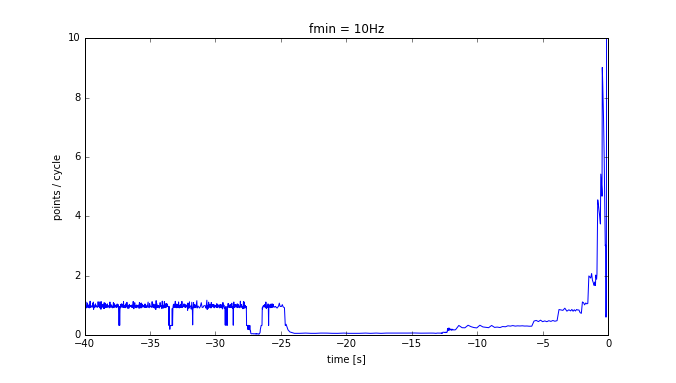

In [142]:
plt.plot(tL[idx_ok2], pts_per_cycle_romsplineL[idx_ok2])
plt.xlim([-40, 0])
plt.ylim([0, 10])
plt.xlabel('time [s]')
plt.ylabel('points / cycle')
plt.title('fmin = 10Hz');

Ansatz for number of points per cycle in romspline grid
$p(t) = 1 + 10 \exp(t-t_c)$

Or, in terms of the phase, we could use
$p(\phi) = 1 + 10 \exp\left[0.01 (\phi-\phi_c)\right]$,
where $\phi > 0$, increasing monotonically from the starting frequency. 

In [210]:
def pts_per_cycle_function(x, n=1.0, a=10.0, sigma=0.01):
    """
    A function providing a constant numer of points per cycle in the inspiral
    with an increase close to merger.
    The functional form is motivated by comparing against romspline grids for the phase
    and smoothing the data.
    Input: x = phi - phi_c
    """
    return n + a*np.exp(sigma*x)

<IPython.core.display.Javascript object>


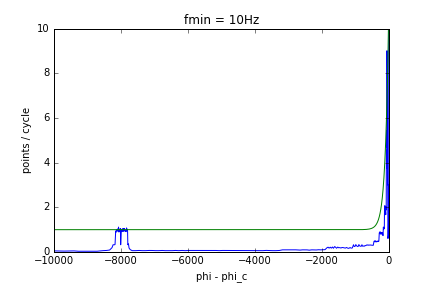

In [199]:
x = -phiLok[idx_ok2]
plt.plot(-phiLok[idx_ok2] - max(x), pts_per_cycle_romsplineL[idx_ok2])
plt.plot(x - max(x), pts_per_cycle_function(x - max(x), n=1.0, a=10.0, sigma=0.01))
plt.xlim([-10000, 0])
plt.ylim([0, 10]);
plt.xlabel('phi - phi_c')
plt.ylabel('points / cycle')
plt.title('fmin = 10Hz');

<IPython.core.display.Javascript object>


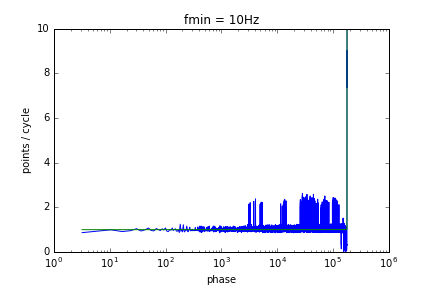

In [201]:
plt.semilogx(-phiLok[idx_ok2], pts_per_cycle_romsplineL[idx_ok2])
x = -phiLok[idx_ok2]
plt.plot(x, pts_per_cycle_function(x - max(x), n=1.0, a=10.0, sigma=0.01))
plt.ylim([0, 10])
plt.xlabel('phase')
plt.ylabel('points / cycle')
plt.title('fmin = 10Hz');

<IPython.core.display.Javascript object>


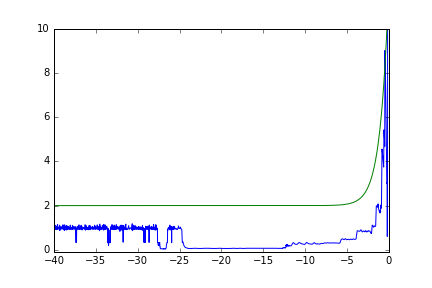

In [162]:
plt.plot(tL[idx_ok2], pts_per_cycle_romsplineL[idx_ok2])
plt.xlim([-40, 0])
plt.ylim([-0.1, 10])
plt.plot(tL[idx_ok2], 2 + 10*np.exp(1*tL[idx_ok2]));

<IPython.core.display.Javascript object>


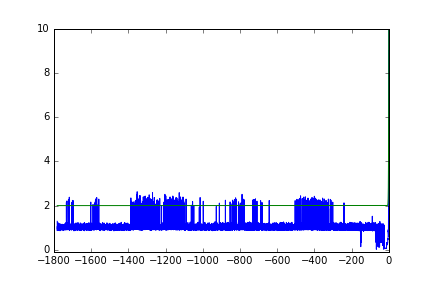

In [161]:
plt.plot(tL[idx_ok2], pts_per_cycle_romsplineL[idx_ok2])
#plt.xlim([-40, 0])
plt.ylim([-0.1, 10])
plt.plot(tL[idx_ok2], 2 + 10*np.exp(1*tL[idx_ok2]));

A grid with 10 points per cycle would be overkill in the inspiral. It is more efficient to use a grid that increases the number of points from the inspiral towards the merger.

<IPython.core.display.Javascript object>


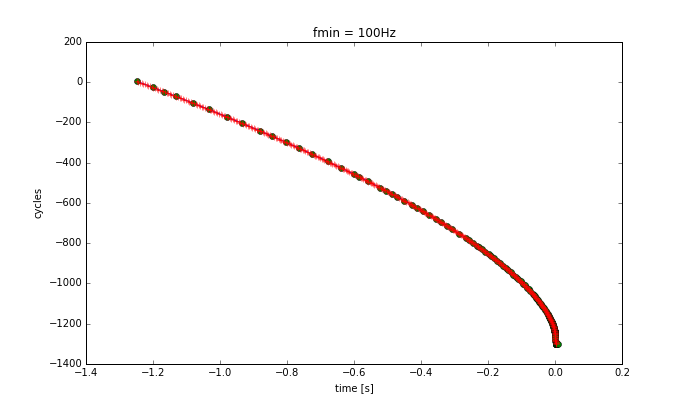

In [143]:
plot(t, phi)
plot(spline_phi.X, phiI(spline_phi.X), 'o')
plot(t_grid, phase_grid, 'r+')
plt.xlabel('time [s]')
plt.ylabel('cycles')
plt.title('fmin = 100Hz');

<IPython.core.display.Javascript object>


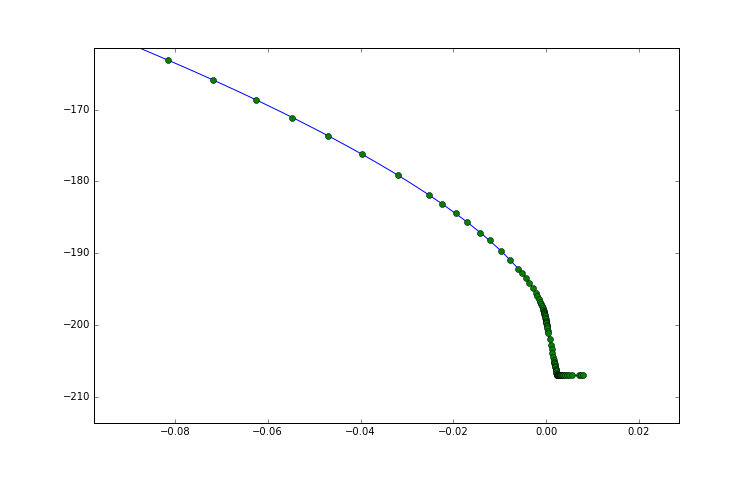

In [28]:
plot(t, phi/(2*pi))
plot(spline_phi.X, phiI(spline_phi.X)/(2*pi), 'o')

## Generate phase grid with variable points per cycle

In [247]:
def Generate_phase_grid(t, phi):
    """
    Using raw time and phase data, construct a grid that has
    a specific number of points per cycle.
    """
    # Make sure that the phase data is monotonically increasing
    # This is required for the spline interpolation below
    tm, phim = monotonically_increasing_timeseries(t, -phi)
    
    i = 0
    phi_max = max(phim)
    phi_g = [phim[i]]

    while phi_g[i] < phi_max:
        p = pts_per_cycle_function(phi_g[i] - phi_max, n=1.0, a=10.0, sigma=0.01)
        phi_new = phi_g[i] + 2*np.pi / p
        phi_g.append(phi_new)
        i += 1
    phase_grid = np.array(phi_g[:-1])
    
    # Compute time values from spline of original data
    t_grid = spline(phim, tm)(phase_grid)
    
    return t_grid, phase_grid

In [248]:
t_grid, phase_grid = Generate_phase_grid(t, phi)

<IPython.core.display.Javascript object>


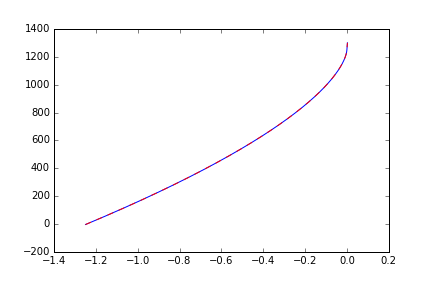

In [249]:
plot(tm, phim, '-')
plot(t_grid, phi_g, 'r--')

<IPython.core.display.Javascript object>


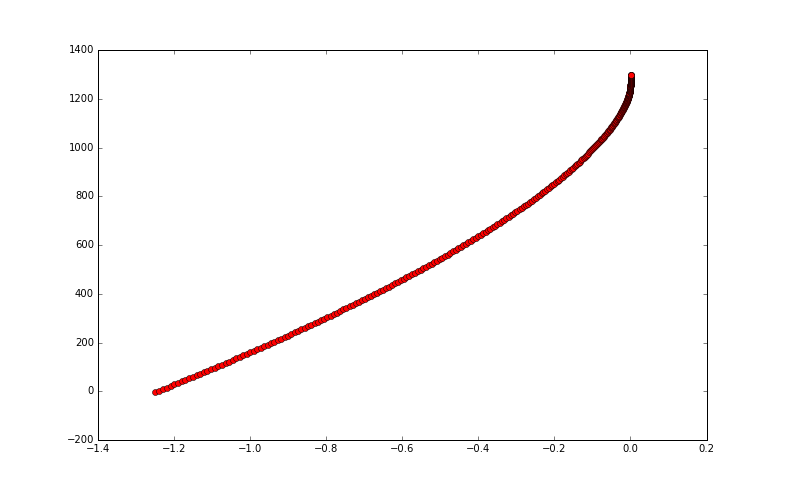

In [246]:
plot(tm, phim, '-')
plot(t_grid, phi_g, 'ro')

<IPython.core.display.Javascript object>


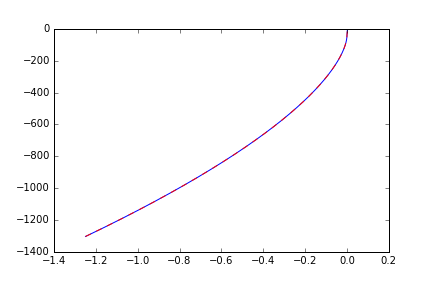

In [244]:
plot(tm, phim - phi_max, '-')
plot(t_grid, phi_g - phi_max, 'r--')

In [222]:
phi_max

1299.5921886437252

<IPython.core.display.Javascript object>


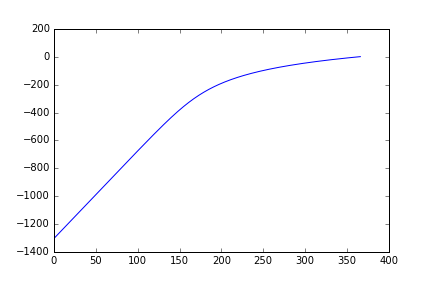

In [220]:
plot(phi_g - phi_max)

## Compare different configurations

In [23]:
t1n, hp1n, hc1n = spin_tidal_eob(2, 2, -0.5, -0.5, 1, 1, 100)
t3n, hp3n, hc3n = spin_tidal_eob(2*3, 2, -0.5, -0.5, 1, 1, 100)

Approximant: TEOBv4
m1=2.00, m2=2.00
s1z=-0.50, s2z=-0.50
delta_t=0.000061, 1/delta_t=1.6384e+04, f_min=100.00
L2A, L2B, L3A, L3B, w2A, w2B, w3A, w3B:
1.0, 1.0, 0.3, 0.3, 0.1820, 0.1820, 0.2396, 0.2396
Approximant: TEOBv4
m1=6.00, m2=2.00
s1z=-0.50, s2z=-0.50
delta_t=0.000061, 1/delta_t=1.6384e+04, f_min=100.00
L2A, L2B, L3A, L3B, w2A, w2B, w3A, w3B:
1.0, 1.0, 0.3, 0.3, 0.1820, 0.1820, 0.2396, 0.2396


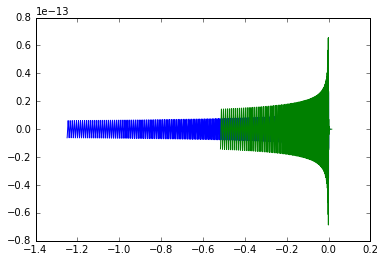

In [24]:
plot(t1, hp1)
plot(t3, hp3)

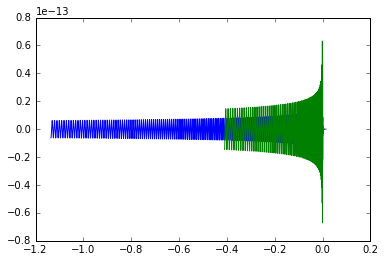

In [25]:
plot(t1n, hp1n)
plot(t3n, hp3n)

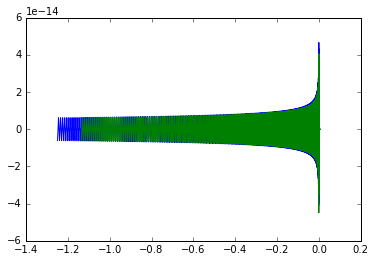

In [26]:
plot(t1, hp1)
plot(t1n, hp1n)

In [27]:
t1T, hp1T, hc1T = spin_tidal_eob(2, 2, 0.5, 0.5, 5000, 5000, 100)

Approximant: TEOBv4
m1=2.00, m2=2.00
s1z=0.50, s2z=0.50
delta_t=0.000061, 1/delta_t=1.6384e+04, f_min=100.00
L2A, L2B, L3A, L3B, w2A, w2B, w3A, w3B:
5000.0, 5000.0, 23024.7, 23024.7, 0.0439, 0.0439, 0.0604, 0.0604


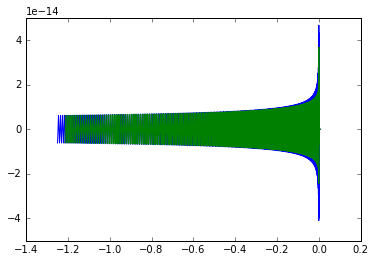

In [28]:
plot(t1, hp1)
plot(t1T, hp1T)

In [31]:
# no longer used
def time_grid_for_longest_waveform(f_min, outdir, deg=5, abstol=5e-5):
    # positive aligned spins and equal mass-ratio increase the length of the waveform in time
    # high lambda also makes the wf shorter, so use lambda ~ 0 here.
    
    m1, m2 = 1.0, 1.0
    s1z, s2z = +0.7, +0.7
    lambda1, lambda2, = 0.1, 0.1
    t, hp, hc = spin_tidal_eob(m1, m2, s1z, s2z, lambda1, lambda2,
                        f_min,
                        distance=1.0, inclination=0.0, delta_t=1.0/16384.0,
                        approximant='TEOBv4', verbose=True)
    # post-process TD data
    h = hp - 1j * hc
    amp = np.abs(h)
    phi = np.unwrap(np.angle(h))
    
    # use a phase romspline for a common grid for amplitude and phase
    spline_phi = romspline.ReducedOrderSpline(t, phi, verbose=True, deg=deg,
                                              tol=abstol, rel=False)

    print 'Generation of phase romspline finished.'
    print 'Size of romspline', spline_phi.size
    print 'Compression factor of romspline', spline_phi.compression
    print 'Resulting spline points in time', spline_phi.X

    phiI = ip.InterpolatedUnivariateSpline(t, phi)
    ampI = ip.InterpolatedUnivariateSpline(t, amp)
    
    np.save(outdir+'time_grid_debug.npy', [t, hp, hc, amp, phi, spline_phi.X])
    np.save(outdir+'time_grid.npy', spline_phi.X)


## Debug nans in amplitude

### Functions

In [14]:
def pts_per_cycle_function(x, n=1.0, a=10.0, sigma=0.01):
    """
    A function providing a constant numer of points per cycle in the inspiral
    with an increase close to merger.
    The functional form is motivated by comparing against romspline grids for the phase
    and smoothing the data, fitting the shape "by eye".
    Input: x = phi - phi_c
    """
    return n + a*np.exp(sigma*x)

#------------------------------------------------------------------------------
def monotonically_increasing_timeseries(t, v, return_idx=False):
    """
Return the part of a timeseries where the independent and dependent
variables are not monotonically increasing from the start of the data
    """
    idx_t = np.where(np.diff(t) < 0)[0]
    idx_v = np.where(np.diff(v) < 0)[0]

    if len(idx_t) == 0:
        idx_t = len(t)
    else:
        idx_t = idx_t[0]
    if len(idx_v) == 0:
        idx_v = len(v)
    else:
        idx_v = idx_v[0]

    i = min(idx_t, idx_v)

    if return_idx:
        return i
    else:
        return t[:i], v[:i]

#------------------------------------------------------------------------------
def Generate_phase_grid(t, phi):
    """
    Using raw time and phase data, construct a grid that has
    a specific number of points per cycle.
    """
    # Make sure that the phase data is monotonically increasing
    # This is required for the spline interpolation below
    tm, phim = monotonically_increasing_timeseries(t, -phi)

    i = 0
    phi_max = max(phim)
    phi_g = [phim[i]]

    while phi_g[i] < phi_max:
        p = pts_per_cycle_function(phi_g[i] - phi_max, n=1.0, a=10.0, sigma=0.01)
        phi_new = phi_g[i] + 2*np.pi / p
        phi_g.append(phi_new)
        i += 1
    phase_grid = np.array(phi_g[:-1])

    # Compute time values from spline of original data
    t_grid = spline(phim, tm)(phase_grid)

    return t_grid, phase_grid


### Analysis

In [4]:
ls tmp

TEOB_TD_38.npy      TEOB_TD_38_raw.npy


In [15]:
tS, phiS, ampS = np.load('tmp/TEOB_TD_38.npy') # data on sparse grid
t, phi, amp = np.load('tmp/TEOB_TD_38_raw.npy')

In [16]:
np.isnan(tS)

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [17]:
tS

array([ nan,  nan,  nan, ...,  nan,  nan,  nan])

In [20]:
ampI = spline(t, amp, k=3, ext='zeros')
t_grid, phase_grid = Generate_phase_grid(t, phi)
amp_on_grid = ampI(t_grid)

In [21]:
t_grid

array([ nan,  nan,  nan, ...,  nan,  nan,  nan])

In [24]:
np.isnan(phase_grid).any()

False

See what's happening inside Generate_phase_grid():

In [25]:
tm, phim = monotonically_increasing_timeseries(t, -phi)

i = 0
phi_max = max(phim)
phi_g = [phim[i]]

while phi_g[i] < phi_max:
    p = pts_per_cycle_function(phi_g[i] - phi_max, n=1.0, a=10.0, sigma=0.01)
    phi_new = phi_g[i] + 2*np.pi / p
    phi_g.append(phi_new)
    i += 1
phase_grid = np.array(phi_g[:-1])

# Compute time values from spline of original data
t_grid = spline(phim, tm)(phase_grid)

In [29]:
np.isnan(phim).any()

False

In [30]:
np.isnan(tm).any()

False

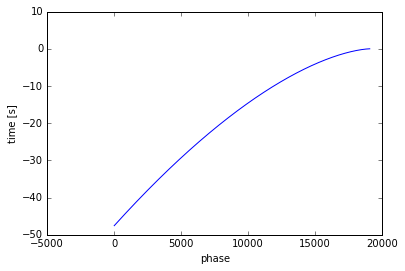

In [39]:
plot(phim, tm);
xlabel('phase')
ylabel('time [s]');

In [35]:
idx_ok = np.where(np.diff(phim) > 0)
idx_bad = np.where(np.diff(phim) <= 0)

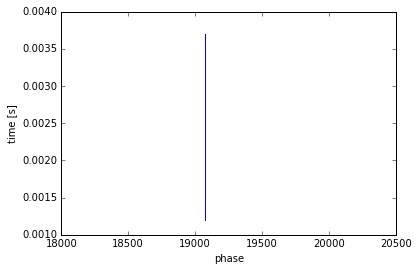

In [40]:
plot(phim[idx_bad], tm[idx_bad]);
xlabel('phase')
ylabel('time [s]');

In [41]:
t_grid = spline(phim[idx_ok], tm[idx_ok])(phase_grid)

In [44]:
np.isnan(t_grid).any()

False

In [45]:
amp_on_grid = ampI(t_grid)

In [46]:
np.isnan(amp_on_grid).any()

False